# Project 1: Final Project
## Handwriting generating with RNN


<p class="lead">
<a href="https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info">Creative Applications of Deep Learning with Google's Tensorflow</a><br />
<a href="http://pkmital.com">Parag K. Mital</a> / <a href="https://twitter.com/rndbrtrnd">Arnaud Bertrand</a><br />
<a href="https://www.kadenze.com">Kadenze, Inc.</a>
</p>

# Table of Contents

- [Overview](#overview)
- [Fetching the network](#fetching-network)
  - [Import from the checkpoint](#import-from-chekpoint)
  - [Network structure](#net-structure) 
  - [Generating some samples](#generating-samples)
- [From static to motion](#from-static-to-motion)
- [glyphs-rnn](#glyphs-rnn)

<a name="overview"></a>
# Overview

Few guidance is given for the project, especially compared to the sessions. This is good, since it pushes me to develop my creative skills. It could also be overwhelming, so I have decided to take few working assumptions.

The main one is to use a pre-designed net, ideally even a pre-trained one, and to work around it. Designing an advanced NN requires a lot of effort, training it involves a lot of computing power (not to mention the iterations). On the contrary, importing a net with the trained parameters is super easy. It has been done several times in the course, like with the Google inception v5 to generate deep dream pictures. Another assumption is to use a RNN. This architecture is incredibly powerful and has a high potential for generative Art.

Before joining the course, I have been following the generative artist [Anders Hoff](https://twitter.com/inconvergent) for a couple of months, and I remember to have been amazed by the [Sand Glyphs](http://inconvergent.net/generative/sand-glyphs/) and the powerful effect of this asemic writing. Note that this algorithm is not based on neural nets. Then I have discovered [Hardmaru](https://twitter.com/hardmaru) by the impressive [large images generation from latent vectors](http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/). It happens that Hardmaru has implemented with TensorFlow a random handwriting generation based on the Alex Graves' [paper](http://arxiv.org/abs/1308.0850). Handwriting is highly personal, expressive and unique, so having an algorithm generating its own style is just AWESOME. It looks like a perfect playground for exploration.

The implementation of  Hardmaru is available on [GitHub](https://github.com/hardmaru/write-rnn-tensorflow). It was based on Python 2 and TensorFlow r0.5. The first step has been to upgrade it to Python 3 and TensorFlow r0.11. Hardmaru has been nice enough to merge my push requests into the main repository. The network had to be trained again, but since there is no change of design, and I knew that the training would last a couple of hours on a CPU, it was OK.

**Note:** the content of this repository heavily relies on the Hardmaru' implementation of the random handwriting generation.

In [1]:
# Let's improt the usual tools
import tensorflow as tf
import matplotlib.pyplot as plt

import subprocess
import sys
import os
import pickle

%matplotlib inline

In [2]:
# Bit of formatting because I have good taste too:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

<a name="fetching-network"></a>
# Fetching the network

<a name="import-from-chekpoint"></a>
## Import from the checkpoint

As a prerequisite, clone locally ``write-rnn-tensorflow`` and update the static variable ``WRITE_RNN_DIR`` to the location of your clone. We will then import a module containing the network and some utils functions.

In [3]:
WRITE_RNN_DIR = '../../write-rnn-tensorflow'
sys.path.append(WRITE_RNN_DIR)

from model import Model
from utils import *

If everything runs fine, you can now import the neural net.

In [4]:
# Initiate TF
with open(os.path.join(WRITE_RNN_DIR, 'save', 'config.pkl'), 'rb') as f:
    saved_args = pickle.load(f)
tf.reset_default_graph()
model = Model(saved_args, True)
sess = tf.InteractiveSession()
saver = tf.train.Saver()

# Load the model
ckpt = tf.train.get_checkpoint_state(os.path.join(WRITE_RNN_DIR, 'save'))
saver.restore(sess, ckpt.model_checkpoint_path)

print("model loaded from: ", ckpt.model_checkpoint_path)
print("saved parameters: ", saved_args)

model loaded from:  ../../write-rnn-tensorflow/save/model.ckpt-11000
saved parameters:  Namespace(batch_size=1, data_scale=20, decay_rate=0.95, grad_clip=10.0, keep_prob=0.8, learning_rate=0.005, model='lstm', num_epochs=30, num_layers=2, num_mixture=20, rnn_size=256, save_every=500, seq_length=1)


<a name="net-structure"></a>
## Network structure

Let's have a look at the graph. As you can see, the architecture is a RNN based on LSTM cells. This network is reasonably complex. You can refer to the original blog post, [Handwriting Generation Demo in TensorFlow]( http://blog.otoro.net/2015/12/12/handwriting-generation-demo-in-tensorflow/) for all the details and rationals. To speak the truth, I didn't spend too much time on it. I would get back to it one day.

In [5]:
g = tf.get_default_graph()
names = [op.name for op in g.get_operations()]
print(names)

['Placeholder', 'Placeholder_1', 'pack', 'zeros/Const', 'zeros', 'rnnlm/output_w', 'rnnlm/output_w/Initializer/random_uniform/shape', 'rnnlm/output_w/Initializer/random_uniform/min', 'rnnlm/output_w/Initializer/random_uniform/max', 'rnnlm/output_w/Initializer/random_uniform/RandomUniform', 'rnnlm/output_w/Initializer/random_uniform/sub', 'rnnlm/output_w/Initializer/random_uniform/mul', 'rnnlm/output_w/Initializer/random_uniform', 'rnnlm/output_w/Assign', 'rnnlm/output_w/read', 'rnnlm/output_b', 'rnnlm/output_b/Initializer/random_uniform/shape', 'rnnlm/output_b/Initializer/random_uniform/min', 'rnnlm/output_b/Initializer/random_uniform/max', 'rnnlm/output_b/Initializer/random_uniform/RandomUniform', 'rnnlm/output_b/Initializer/random_uniform/sub', 'rnnlm/output_b/Initializer/random_uniform/mul', 'rnnlm/output_b/Initializer/random_uniform', 'rnnlm/output_b/Assign', 'rnnlm/output_b/read', 'split/split_dim', 'split', 'Squeeze', 'rnnlm_1/MultiRNNCell/Cell0/Slice/begin', 'rnnlm_1/MultiRNNCel

<a name="generating-samples"></a>
## Generating some samples

There is a convenient method in the ``model`` object to generate a sample. The statement below will generate a sample of length ``SAMPLE_LENGTH``. I will explain just after the meaning of outputs ``strokes`` and ``params``.

In [6]:
SVG_SCALE_FACTOR = 10
SAMPLE_LENGTH = 800
SAMPLE_FILENAME = 'sample-write-rnn'

[strokes, params] = model.sample(sess, SAMPLE_LENGTH)

The model may be complex, but it is very easy to use. The ``strokes`` numpy array is a list of coordinates, with an additional parameter for each coordinates to indicate if it is the beginning of a new stroke. The coordinates describe a path which is the handwritten line. This is that simple. The ``params`` are the parameters of a mixture 2d gaussian.

In [7]:
print(strokes[10:20])
print(params[40][3])

[[  -1.32683778   12.56639099    0.        ]
 [   5.25921059    4.85087872    0.        ]
 [   5.06441689   -3.15677047    1.        ]
 [ -48.14166641 -133.66757202    0.        ]
 [  -4.22258472   -4.42479563    0.        ]
 [   4.9743185    -2.84449291    0.        ]
 [  11.52417278    1.13354254    0.        ]
 [  24.05890465   -6.6871953     0.        ]
 [  22.04423904   -1.70541584    0.        ]
 [  23.36000824    1.53547513    1.        ]]
[ 0.19990544  0.25341406  1.6402452   0.15698999  0.24937324  0.15278439
  0.45669246  3.07474041  0.28344893  0.54146636  0.14402924  0.81184036
  0.22888623  0.13054909  0.20985968  0.2013675   0.13058165  6.99356556
  0.15047655  0.183413  ]


Hardmaru has built ``utils`` functions to display the ``strokes``. The first one renders simply the handwriting with a black color. The next one changes color at each new stroke, with a delightful effect. As you can see, the text is not intelligible, but it displays many artifacts of the latin handwriting, like the curls, letters with lower and upper parts and even sometimes words. I consider it as a [asemic writing](https://en.wikipedia.org/wiki/Asemic_writing), even if at the first look it could be consider as normal.

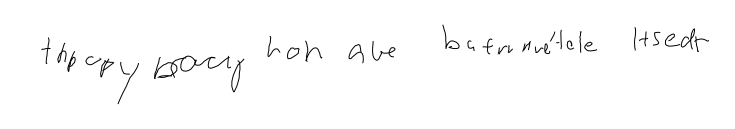

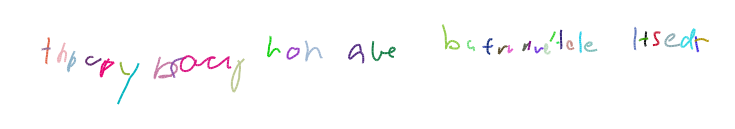

In [8]:
draw_strokes(strokes, factor=SVG_SCALE_FACTOR, svg_filename = SAMPLE_FILENAME+'.normal.svg')
draw_strokes_random_color(strokes, factor=SVG_SCALE_FACTOR, svg_filename = SAMPLE_FILENAME+'.color.svg')

Unfortunately there is no option to parametrize the output. You cannot input a string in this network like in the Alex Graves’ demo. Moreover, you may expect a kind of latent space here. Interesting thoughts for a next project.

<a name="from-static-to-motion"></a>
# From static to motion

In this part I will generate a gif to watch the network in action. Each frame will be a part of a step further in the overall path. I will also crop and move the center position along. I have created my own utils library to keep the code in the notebook more readable. 

In [9]:
from libs import utils, svg_utils

GIF_MARGIN = 25
GIF_STEP = 5
GIF_LENGTH = 800
GIF_FILENAME = 'write-rnn'
CONVERT_DENSITY = 400
TEMP_FILES = os.path.join('tmp', 'gif-frame-tmp')

if not os.path.exists('tmp'):
    os.mkdir('tmp')

Run the following statements until the RNN generates something fitting your taste.

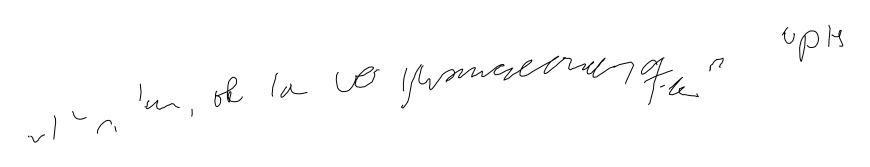

In [10]:
[strokes, _] = model.sample(sess, GIF_LENGTH)
draw_strokes(strokes, factor=SVG_SCALE_FACTOR, svg_filename = GIF_FILENAME+'.svg')

The text below will generate a ``.gif`` from the handwritting. Since the pace is not perfectly linear, you may have to adjust the parameters. For example, you can adapt the ``MARGIN`` parameter to add some buffer.

In [11]:
# Get size and frame
min_x, max_x, min_y, max_y = get_bounds(strokes, SVG_SCALE_FACTOR)
size_x = GIF_MARGIN * 2 + max_x - min_x
size_y = GIF_MARGIN * 2 + max_y - min_y
abs_x = GIF_MARGIN - min_x
abs_y = GIF_MARGIN - min_y

# Loop
imgs = []
for i in range(int(GIF_LENGTH * 4 / 100), len(strokes)):
    if (i % GIF_STEP) == 0:
        dwg = svg_utils.initiate(size_x, size_y, TEMP_FILES+'.svg')
        svg_utils.add_row_strokes(dwg, abs_x, abs_y, strokes[:i], SVG_SCALE_FACTOR)
        dwg.save()
        img = svg_utils.convert_to_img(TEMP_FILES+'.svg', TEMP_FILES+'.png', CONVERT_DENSITY)
        he, le, _ = img.shape
        pos = int((i / len(strokes)) * (le - he))
        print('frame:', i, 'position:', pos, '/', le)
        gif_frame = utils.img_crop(img, pos)
        imgs.append(gif_frame)

frame: 35 position: 170 / 4833
frame: 40 position: 195 / 4833
frame: 45 position: 219 / 4833
frame: 50 position: 243 / 4833
frame: 55 position: 268 / 4833
frame: 60 position: 292 / 4833
frame: 65 position: 316 / 4833
frame: 70 position: 341 / 4833
frame: 75 position: 365 / 4833
frame: 80 position: 390 / 4833
frame: 85 position: 414 / 4833
frame: 90 position: 438 / 4833
frame: 95 position: 463 / 4833
frame: 100 position: 487 / 4833
frame: 105 position: 511 / 4833
frame: 110 position: 536 / 4833
frame: 115 position: 560 / 4833
frame: 120 position: 585 / 4833
frame: 125 position: 609 / 4833
frame: 130 position: 633 / 4833
frame: 135 position: 658 / 4833
frame: 140 position: 682 / 4833
frame: 145 position: 706 / 4833
frame: 150 position: 731 / 4833
frame: 155 position: 755 / 4833
frame: 160 position: 780 / 4833
frame: 165 position: 804 / 4833
frame: 170 position: 828 / 4833
frame: 175 position: 853 / 4833
frame: 180 position: 877 / 4833
frame: 185 position: 901 / 4833
frame: 190 position: 

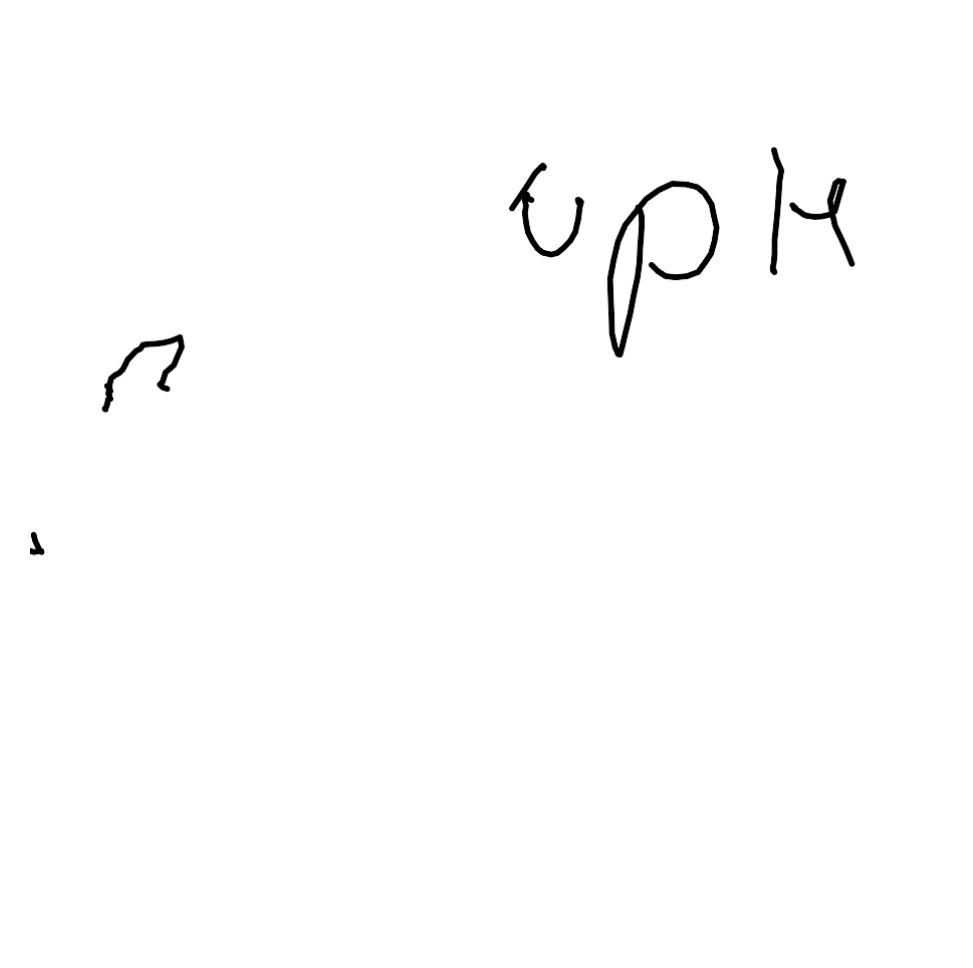

In [12]:
_ = utils.build_gif(imgs, interval=0.1, saveto=GIF_FILENAME+'.gif', show_gif=False)

<a name="glyphs-rnn"></a>
# glyphs-rnn

In this part, I will I make the RNN handwrite several lines with a layout similar to ``sand-glyphs``. The parameters below can be adjusted to generate different setup.

In [13]:
SIZE = 1400
GLYPHS_MARGIN = 50
ROW_NUM = 12

SAMPLE_LENGTH = 1200
CONVERT_DENSITY_GLYPHS = 100

SVG_FILENAME = 'glyphs-rnn'

The following function generates the output. The parameters are an array of ``strokes`` similar to what has been regenerated previously and the width of the pen.  

In [14]:
def print_strokes(data, stroke_width=3):
    spacing = (SIZE - 2 * GLYPHS_MARGIN) / ROW_NUM
    dwg = svg_utils.initiate(SIZE, SIZE, SVG_FILENAME+'.svg')
    for tup in enumerate(data):
        min_x, max_x, min_y, max_y = get_bounds(tup[1], SVG_SCALE_FACTOR)
        print('row:', tup[0], 'length:', max_x - min_x, 'height:', max_y - min_y)
        abs_x = GLYPHS_MARGIN - min_x 
        abs_y = GLYPHS_MARGIN + tup[0] * spacing - min_y
        svg_utils.add_row_strokes(dwg, abs_x, abs_y, tup[1], SVG_SCALE_FACTOR, stroke_width=stroke_width)
    dwg.save()
    img = svg_utils.convert_to_img(SVG_FILENAME+'.svg', SVG_FILENAME+'.png', CONVERT_DENSITY_GLYPHS)
    return img

In [15]:
strokes_rows = []
for _ in range(ROW_NUM):
    [strokes, _] = model.sample(sess, SAMPLE_LENGTH)
    strokes_rows.append(strokes)

row: 0 length: 946.1610717093096 height: 87.46173874642699
row: 1 length: 1264.6630070997405 height: 66.26502695530652
row: 2 length: 1153.0961902284998 height: 74.3181396842003
row: 3 length: 874.7805391770783 height: 86.27506601624191
row: 4 length: 985.1132256267609 height: 56.980656281858685
row: 5 length: 928.2963299306108 height: 83.33108165580778
row: 6 length: 952.616783194989 height: 60.07517280578613
row: 7 length: 1054.7940374117336 height: 102.2678239410743
row: 8 length: 939.7610759148379 height: 73.27652436236386
row: 9 length: 1093.240098630031 height: 61.81956684440377
row: 10 length: 1045.4147955112614 height: 77.09788457155227
row: 11 length: 1038.6608236151749 height: 57.399785947799685


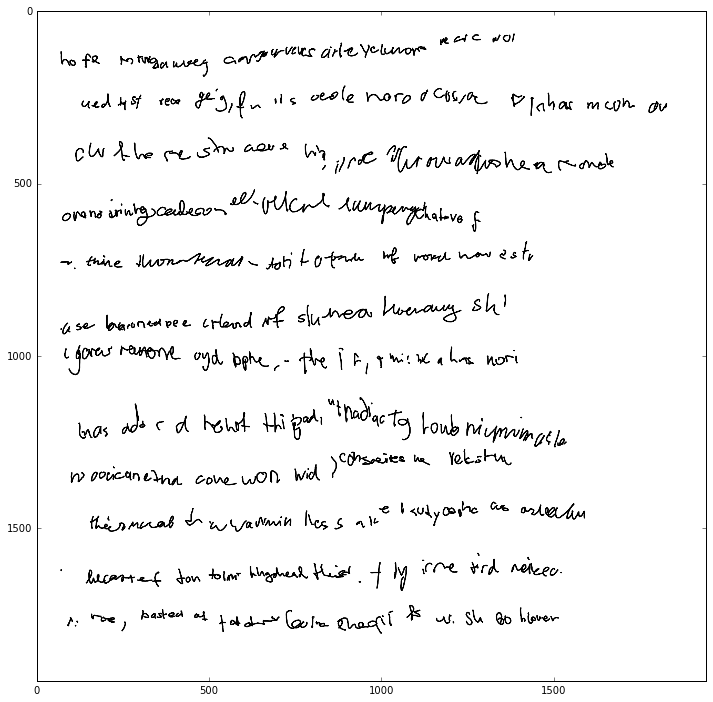

In [16]:
img = print_strokes(strokes_rows)
plt.figure(figsize=(12, 12))
plt.imshow(img)

With the previous code, the handwriting is generally disturbing. Several styles are mixed together on the same page, like if the text has been written by several people, or even worst, by someone with strong personality issues. This makes me uncomfortable. We cannot influence the style and make it consistent (interesting challenge, though), so one simple option is to drop the lines out of a given range.

In [17]:
MAX_LENGTH = 1250
MAX_HEIGHT = 85

In [18]:
strokes_rows = []
for _ in range(ROW_NUM):
    while True:
        [strokes, _] = model.sample(sess, SAMPLE_LENGTH)
        min_x, max_x, min_y, max_y = get_bounds(strokes, SVG_SCALE_FACTOR)
        print('length:', max_x - min_x, 'height:', max_y - min_y)
        if max_x - min_x < MAX_LENGTH and max_y - min_y < MAX_HEIGHT:
            break
    print('New row added!')
    strokes_rows.append(strokes)

length: 981.4695350393653 height: 67.73288967460392
New row added!
length: 845.3857772592454 height: 124.35980549855162
length: 942.3394921306058 height: 94.82958171106874
length: 1151.1768849867774 height: 115.42540822178125
length: 1176.3658182932516 height: 87.89077678781466
length: 1284.595531241968 height: 140.78872212469582
length: 1300.4058808892971 height: 66.70206653000788
length: 824.120006485028 height: 56.685251655057066
New row added!
length: 940.1975640339897 height: 90.20380237922073
length: 1000.4953570881853 height: 60.59662893712522
New row added!
length: 1009.0653505727644 height: 64.30604149261491
New row added!
length: 1139.4285638428287 height: 62.16292794728655
New row added!
length: 1045.8528399529632 height: 90.91903398744762
length: 1191.4331284931866 height: 63.08524318169802
New row added!
length: 1006.3252047633749 height: 112.07996552926491
length: 1351.4370081967668 height: 65.59954683482646
length: 1087.8736199198063 height: 81.00832727006639
New row add

row: 0 length: 981.4695350393653 height: 67.73288967460392
row: 1 length: 824.120006485028 height: 56.685251655057066
row: 2 length: 1000.4953570881853 height: 60.59662893712522
row: 3 length: 1009.0653505727644 height: 64.30604149261491
row: 4 length: 1139.4285638428287 height: 62.16292794728655
row: 5 length: 1191.4331284931866 height: 63.08524318169802
row: 6 length: 1087.8736199198063 height: 81.00832727006639
row: 7 length: 948.253567800214 height: 83.39043327141556
row: 8 length: 1054.2897389361656 height: 73.69228147501127
row: 9 length: 1008.6657635451285 height: 69.45910965129733
row: 10 length: 844.9713419725194 height: 51.89170204475522
row: 11 length: 1204.7219121761598 height: 67.10336990766228


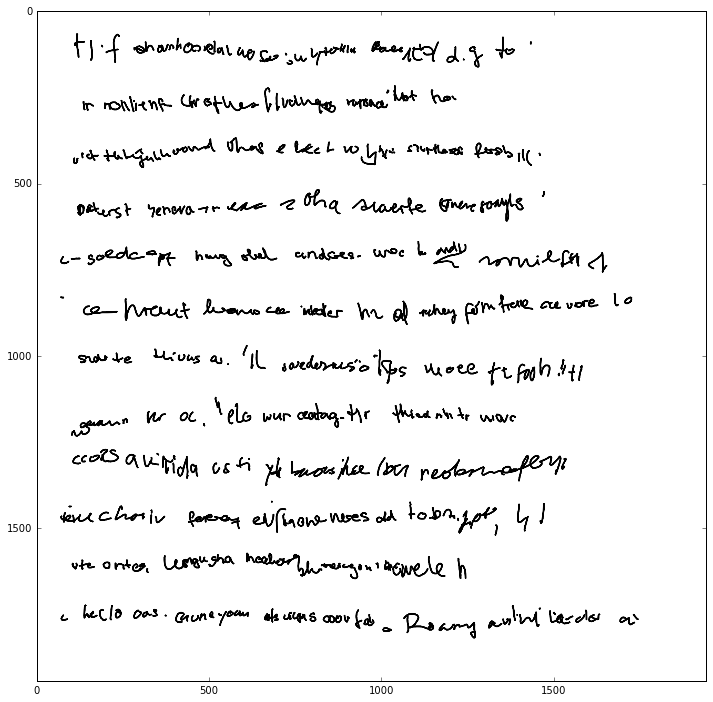

In [19]:
img = print_strokes(strokes_rows, 4)
plt.figure(figsize=(12, 12))
plt.imshow(img)

This ``write-rnn`` network is just amazing. I consider to improve the net to make it write an input string, have a more consistent style and what would even be better, to control that style with a latent vector! Still a lot of fun to come.